# Final Project
## Lars Kühmichel, Nicolas Wolf

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from fproject_get_data import preprocess_and_save_data, load_and_plot_data

In [3]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

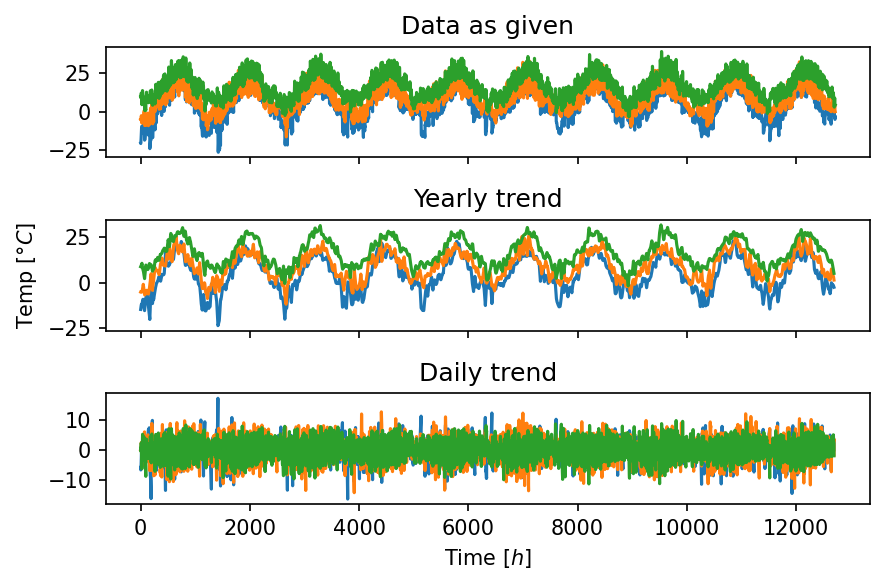

In [4]:
#preprocess_and_save_data()
npa, mnpa = load_and_plot_data()

## 1 Train-test split
First 8 years train set, last 2 years test set

In [5]:
ratio = 0.8
x_train = mnpa[:int(ratio*len(mnpa))]
x_test = mnpa[int(ratio*len(mnpa)):]

## 2 VAR(1)-model
$$
z_{t+1}=Az_t+\epsilon_t,\quad\epsilon_t\sim\mathcal{N}(0,\Sigma),\quad z_0\sim\mathcal{N}(\mu_0,\Sigma)
$$
with
$$
x_t = Bz_t+\eta_t,\quad\eta_t\sim\mathcal{N}(0,\Gamma)
$$

In [6]:
class VAR():
    def __init__(self, A, Sigma, mu0, B, Gamma):
        self.set_parameters(A, Sigma, mu0, B, Gamma)
        self.latent_dim = Sigma.shape[0]
        self.obs_dim = Gamma.shape[0]
        
    def set_parameters(self, A, Sigma, mu0, B, Gamma):
        self.A = A
        self.Sigma = Sigma
        self.mu0 = mu0
        self.B = B
        self.Gamma = Gamma
        
    def get_parameters(self):
        return {
            "A": self.A,
            "Sigma": self.Sigma,
            "mu0": self.mu0,
            "B": self.B,
            "Gamma": self.Gamma
        }
        
    def generate_time_series(self, T):
        z = np.zeros(shape=(T, self.latent_dim))
        x = np.zeros(shape=(T, self.obs_dim))
        
        epsilon = np.random.multivariate_normal(np.zeros(self.latent_dim), self.Sigma, size=T)
        eta = np.random.multivariate_normal(np.zeros(self.obs_dim), self.Gamma, size=T)

        
        z[0] = np.random.multivariate_normal(self.mu0, self.Sigma)
        x[0] = self.B @ z[0] + eta[0]
        
        for t in range(1, T):
            z[t] = self.A @ z[t-1] + epsilon[t]
            x[t] = self.B @ z[t] + eta[t]
            
        return z, x
    
    def estimate_parameters(self, x, E_z, E_zz, E_zz1):
        """
        x = observed time series of shape (T, obs_dim)
        E_z = (E[z_t])_t of shape (T, latent_dim)
        E_zz = (E[z_t @ z_t^T])_t of shape(T, latent_dim, latent_dim)
        E_zz1 = (E[z_t @ z_{t-1}^T])_t of shape (T-1, latent_idm, latent_dim)
        """
        T = len(x)
        
        #A_new = np.sum(E_zz1, axis=0) @ np.linalg.inv(np.sum(E_zz[:-1], axis=0).astype(dtype=np.float64)).astype(dtype=np.longdouble)
        A_new = np.linalg.solve(np.sum(E_zz[:-1], axis=0).T, np.sum(E_zz1, axis=0).T).T
        
        Sigma_new = 1/T * (np.sum(E_zz[1:], axis=0) - A_new @ np.sum(E_zz1, axis=0).T)
        #Sigma_new += 1e-3 * np.eye(Sigma_new.shape[0])
        Sigma_new = np.diag(np.diag(Sigma_new))
        
        mu0_new = E_z[0]
        
        sum_t_x_Ez = np.einsum("ij,il->jl", x, E_z)
        
        #B_new = sum_t_x_Ez @ np.linalg.inv(np.sum(E_zz, axis=0).astype(dtype=np.float64)).astype(dtype=np.longdouble)
        B_new = np.linalg.solve(np.sum(E_zz, axis=0).T, sum_t_x_Ez.T).T
        
        sum_t_x_Ez_BT = sum_t_x_Ez @ B_new.T
        Gamma_new = 1/T * (np.einsum("ij,il->jl", x, x) - sum_t_x_Ez_BT - sum_t_x_Ez_BT.T + B_new @ np.sum(E_zz, axis=0) @ B_new.T)
        #Gamma_new += 1e-3 * np.eye(Gamma_new.shape[0])
        Gamma_new = np.diag(np.diag(Gamma_new))
        
        return A_new, Sigma_new, mu0_new, B_new, Gamma_new
    
    def expected_log_likelihood(self, x, E_z, E_zz, E_zz1):
        Sigma_inv = np.linalg.inv(self.Sigma)
        Gamma_inv = np.linalg.inv(self.Gamma)
        T = len(x)
        
        ell = T*np.linalg.slogdet(self.Sigma)[1] + T*np.linalg.slogdet(self.Gamma)[1]
        ell += np.trace(Sigma_inv @ E_zz[1:], axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.A.T @ Sigma_inv @ E_zz1, axis1=1, axis2=2).sum()
        ell += np.trace(self.A.T @ Sigma_inv @ self.A @ E_zz[:-1], axis1=1, axis2=2).sum()
        
        ell += np.trace(Gamma_inv @ np.einsum("ij,il->ijl", x, x), axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.B.T @ Gamma_inv @ np.einsum("ij,il->ijl", x, E_z), axis1=1, axis2=2).sum()
        ell += np.trace(self.B.T @ Gamma_inv @ self.B @ E_zz, axis1=1, axis2=2).sum()
        
        return -ell / 2.

In [7]:
def Kalman_Filter_Smoother(x, A, Sigma, mu0, B, Gamma, L0):
    p = Sigma.shape[0]
    q = Gamma.shape[0]
    T = len(x)
    K = np.zeros(shape=(T, p, q))
    L = np.zeros(shape=(T, p, p))
    mu = np.zeros(shape=(T, len(mu0)))
    V = np.zeros(shape=(T, p, p))
    mu_tilde = np.zeros(shape=mu.shape)
    V_tilde = np.zeros(shape=V.shape)
    V_tt1 = np.zeros(shape=V.shape) # = cov_theta[z_t,z_{t-1} | {x_t}_{t=1...T}]
    
    # Kalman Filter
    #K[0] = L0 @ B.T @ np.linalg.inv((B @ L0 @ B.T + Gamma).astype(dtype=np.float64)).astype(dtype=np.longdouble)
    K[0] = np.linalg.solve((B @ L0 @ B.T + Gamma).T, (L0 @ B.T).T).T
    V[0] = (np.eye(p) - K[0] @ B) @ L0
    L[0] = L0
    mu[0] = mu0 + K[0] @ (x[0] - B @ mu0)
    
    for t in range(1, T):
        L[t] = A @ V[t-1] @ A.T + Sigma
        #K[t] = L[t] @ B.T @ np.linalg.inv((B @ L[t] @ B.T + Gamma).astype(dtype=np.float64)).astype(dtype=np.longdouble)
        K[t] = np.linalg.solve((B @ L[t] @ B.T + Gamma).T, (L[t] @ B.T).T).T
        mu[t] = A @ mu[t-1] + K[t] @ (x[t] - B @ A @ mu[t-1])
        V[t] = (np.eye(p) - K[t] @ B) @ L[t]
        
        
    # Kalman Smoother
    mu_tilde[-1] = mu[-1]
    V_tilde[-1] = V[-1]
    
    for t in range(T-2, -1, -1):
        #J = V[t] @ A.T @ np.linalg.inv(L[t].astype(dtype=np.float64)).astype(dtype=np.longdouble)
        J = np.linalg.solve(L[t].T, (V[t] @ A.T).T).T
        V_tilde[t] = V[t] + J @ (V_tilde[t+1] - L[t]) @ J.T
        mu_tilde[t] = mu[t] + J @ (mu_tilde[t+1] - A @ mu[t])
        V_tt1[t+1] = V_tilde[t+1] @ J.T
    
    return mu, V, mu_tilde, V_tilde, V_tt1

In [27]:
def Expectation_Maximization(var, x, max_iter=100, tol=1e-4):
    expected_log_likelihoods = np.zeros(max_iter)
    parameter_differences = np.zeros(max_iter)
    ell_prev = 0
    pbar = tqdm(range(max_iter))
    pbar.set_description(f"iteration {0}, ell = ")
    for i in pbar:
        old_params = var.get_parameters()
        mu, V, mu_tilde, V_tilde, V_tt1 = Kalman_Filter_Smoother(x=x, L0=var.Sigma, **old_params)
        
        E_z = mu_tilde
        E_zz = V_tilde + np.einsum("ij,il->ijl", E_z, E_z)
        E_zz1 = V_tt1[1:] + np.einsum("ij,il->ijl", E_z[1:], E_z[:-1])
        
        
        new_params = var.estimate_parameters(x, E_z, E_zz, E_zz1)
        var.set_parameters(*new_params)

        ell = var.expected_log_likelihood(x, E_z, E_zz, E_zz1)
        max_parameter_difference = max([np.max(np.abs(new_p - old_p)) for (new_p, old_p) in zip(new_params, old_params.values())])
        
        expected_log_likelihoods[i] = ell
        parameter_differences[i] = max_parameter_difference
        
        pbar.set_description(f"iteration {i+1}, ell = {ell:.{int(-np.log10(tol))}f}, max param difference = {max_parameter_difference:.{int(-np.log10(tol))}f}")
        
        if np.isnan(ell):
            var.set_parameters(**old_params)
            return var, expected_log_likelihoods[:i+1], parameter_differences[:i+1]
            
        #if i > 100 and (ell - ell_prev < tol or max_parameter_difference < tol):
        #if i > 50 and ell - ell_prev > tol * abs(expected_log_likelihoods[0]):
        #    print(f"finished with ell = {ell:.5f}, ell_prev = {ell_prev:.5f}, max param difference = {max_parameter_difference}")
        #    var.set_parameters(**old_params)
        #    return var, expected_log_likelihoods[:i+1], parameter_differences[:i+1]
        
        ell_prev = ell
        
    return var, expected_log_likelihoods, parameter_differences

  0%|          | 0/3000 [00:00<?, ?it/s]

Text(0, 0.5, 'Max Parameter Difference')

<Figure size 900x600 with 0 Axes>

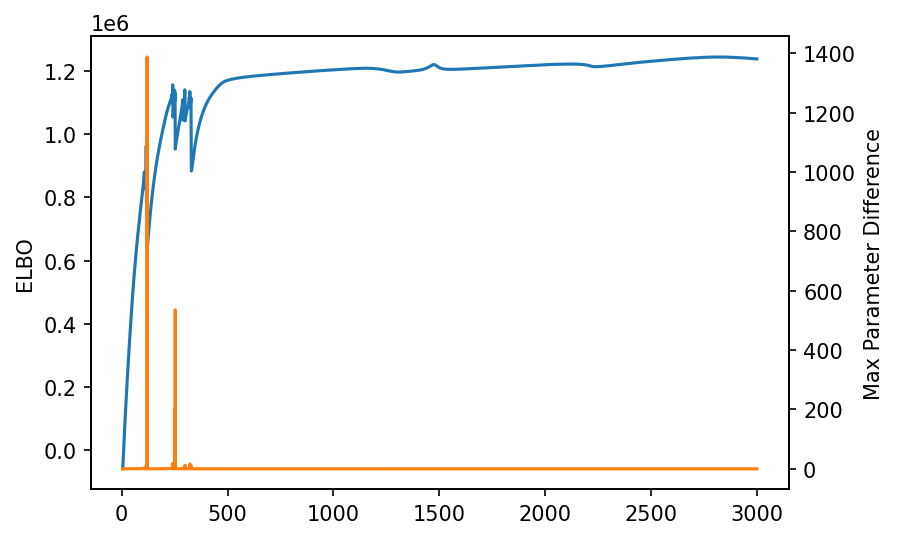

In [29]:
T, obs_dim = x_train.shape
latent_dim = 30
A_initial = np.random.uniform(size=(latent_dim, latent_dim))
Sigma_initial = np.diag(np.random.uniform(low=1e-1, size=latent_dim))
mu0_initial = np.random.uniform(size=latent_dim)
B_initial = np.random.uniform(size=(obs_dim, latent_dim))
Gamma_initial = np.diag(np.random.uniform(low=1e-1, size=obs_dim))

var = VAR(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial)

var, expected_log_likelihoods, parameter_differences = Expectation_Maximization(var, x_train, max_iter=3000)

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start = 5
ax1.plot(np.arange(start, len(expected_log_likelihoods)), expected_log_likelihoods[start:], 'C0')
ax2.plot(np.arange(start, len(expected_log_likelihoods)), parameter_differences[start:], 'C1')
ax1.set_ylabel("ELBO")
ax2.set_ylabel("Max Parameter Difference")

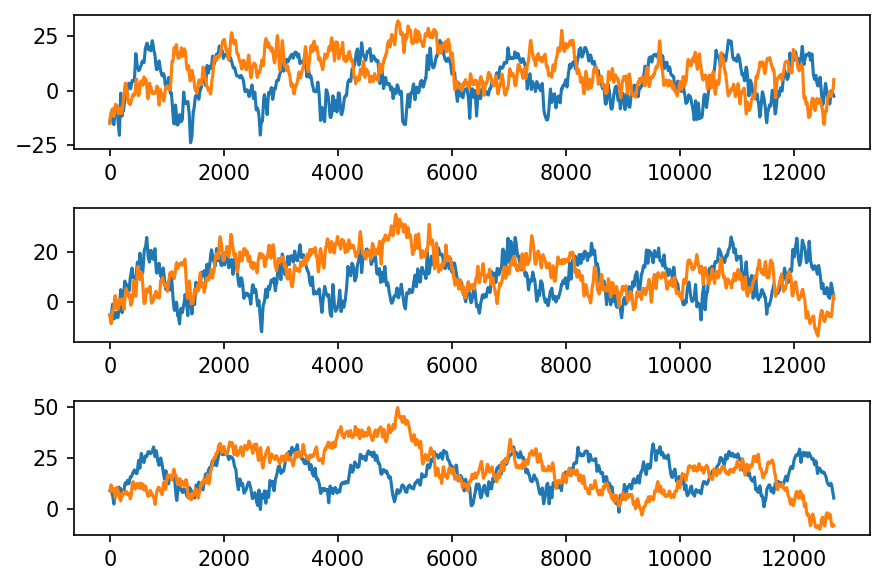

In [22]:
ts = var.generate_time_series(len(mnpa))
fig, axes = plt.subplots(3, 1)
for i in range(3):
    axes[i].plot(mnpa[:,i])
    axes[i].plot(ts[1][:,i])
plt.tight_layout()
plt.show()

In [ ]:
for k, i in var.get_parameters().items():
    with np.printoptions(precision=3, suppress=True, linewidth=400):
        print(k)
        print(i)
        print()
    #np.save(k+".npy", i)